<a href="https://colab.research.google.com/github/peterkenman/Time-Series-Anomaly-Detection-using-SWaT-Dataset-with-Autoencoders-and-Variational-Autoencoders/blob/master/%E3%80%8C1_Introduction_ipynb%E3%80%8DSWaT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu124.html
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

2.4.1+cu121
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 120.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.4/992.4 kB 46.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install utils
!pip install AutoEncoder
#!pip install trainer
#!pip install Module

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=2ef2d917c66911dfee175f5f541530715a1717038ff7709574168d38de024f62
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
#from usad import *
#from AutoEncoder import Encoder, Decoder
import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
import pickle
import numpy as np
#from util import *
from trainer import Trainer
from Module import USAD
import numpy as np
import pandas as pd
from sklearn import preprocessing

ModuleNotFoundError: No module named 'trainer'

In [ ]:
window_length = 12
latent_size = 33
batch_size = 128
lrate = 0.02
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
nepochs = 3000
min_valid_error = np.inf
dataset = "SWaT"
train_valid_split = 0.7
lambda_ = 1.6
train_loss1 = []
train_loss2 = []
valid_loss1 = []
valid_loss2 = []
y_hat = []

In [ ]:
train, test = get_data(dataset)
X_train_  = train[0]
X_test_ = test[0]
y_test_ = test[1]
X_train_ = preprocess(X_train_)
X_test_ = preprocess(X_test_)
X_train_ = X_train_[np.arange(window_length)[None, :] + np.arange(X_train_.shape[0]-window_length)[:, None]]
X_test = X_test_[np.arange(window_length)[None, :] + np.arange(X_test_.shape[0]-window_length)[:, None]]
y_test = y_test_[np.arange(window_length)[None, :] + np.arange(y_test_.shape[0]-window_length)[:, None]]

load data of: SWaT
train:  0 None
test:  0 None


FileNotFoundError: [Errno 2] No such file or directory: 'processed/SWaT_train.pkl'

# Introduction: Hands-on Graph Neural Networks

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

PyTorch Geometric provides an easy access to this dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl
import xlrd
import csv
from openpyxl import load_workbook
%matplotlib inline
from sklearn.decomposition import PCA
# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_selection import VarianceThreshold
import math
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import csv
# Use openpyxl to work with .xlsx files
from openpyxl import load_workbook

def xlsx_to_csv():
    workbook = load_workbook('/content/drive/MyDrive/Colab Notebooks/SWaT_Dataset_Normal_v1.xlsx')
    sheet = workbook.active # Get the active sheet
    with open('swat_train.csv', 'w', encoding='utf-8') as f:
        write = csv.writer(f)
        for row in sheet.iter_rows(): # Iterate over the rows
            row_value = [cell.value for cell in row] # Extract values from cells
            write.writerow(row_value)

if __name__ == '__main__':
    xlsx_to_csv()
    print('done')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


done


In [ ]:
df_train = pd.read_csv('swat_train.csv')
df_train.columns = df_train.columns.str.strip()


<ipython-input-7-daf67d0f48fc>:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('swat_train.csv')


In [ ]:
import csv
# Use openpyxl to work with .xlsx files
from openpyxl import load_workbook

def xlsx_to_csv():
    workbook = load_workbook('/content/drive/MyDrive/Colab Notebooks/SWaT_Dataset_Attack_v0.xlsx')
    sheet = workbook.active # Get the active sheet
    with open('swat_test.csv', 'w', encoding='utf-8') as f:
        write = csv.writer(f)
        for row in sheet.iter_rows(): # Iterate over the rows
            row_value = [cell.value for cell in row] # Extract values from cells
            write.writerow(row_value)

if __name__ == '__main__':
    xlsx_to_csv()
    print('done')


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


done


In [ ]:
df_test = pd.read_csv('swat_train.csv')
df_test.columns = df_test.columns.str.strip()
df = pd.concat([df_train, df_test])

print("Combined data size:", df.shape)
print("Data train size:", df_train.shape)
print("Data test size:", df_test.shape)

<ipython-input-10-90739611dbbc>:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('swat_train.csv')


Combined data size: (990002, 53)
Data train size: (495001, 53)
Data test size: (495001, 53)


In [ ]:
df=df[:600000]

In [ ]:
df.head(-5)

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,0.000000,124.3135,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0,0
1,0.000000,124.3920,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0,0
2,0.000000,124.4705,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0,0
3,0.000000,124.6668,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0,0
4,0.000000,124.5098,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.000000,1.0,...,1.0,1.0,9.100231,0.000000,3.3485,0.000256,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494990,2.535311,522.0617,2.0,2.0,1.0,262.0161,8.393873,328.5055,2.444238,2.0,...,2.0,1.0,251.073400,1.681991,189.8231,0.000128,1.0,1.0,1.0,0
494991,2.512250,522.3757,2.0,2.0,1.0,262.0161,8.393873,328.5055,2.444751,2.0,...,2.0,1.0,251.073400,1.681991,189.8552,0.000128,1.0,1.0,1.0,0
494992,2.499119,522.7290,2.0,2.0,1.0,262.0161,8.393873,328.5055,2.444751,2.0,...,2.0,1.0,251.073400,1.681991,189.8552,0.000128,1.0,1.0,1.0,0
494993,2.484707,522.4935,2.0,2.0,1.0,262.0161,8.393873,328.5055,2.444751,2.0,...,2.0,1.0,251.073400,1.681991,189.8552,0.000128,1.0,1.0,1.0,0


In [ ]:
df.duplicated().sum()

9649

In [ ]:
df.isnull().sum()/len(df)*100

,0
FIT101,0.0
LIT101,0.0
MV101,0.0
P101,0.0
P102,0.0
AIT201,0.0
AIT202,0.0
AIT203,0.0
FIT201,0.0
MV201,0.0


In [ ]:
for c in df.columns[:-2]:
    df[c]=pd.to_numeric(df[c])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495000 entries, 0 to 494999
Data columns (total 52 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIT101         495000 non-null  float64
 1   LIT101         495000 non-null  float64
 2    MV101         495000 non-null  float64
 3   P101           495000 non-null  float64
 4   P102           495000 non-null  float64
 5    AIT201        495000 non-null  float64
 6   AIT202         495000 non-null  float64
 7   AIT203         495000 non-null  float64
 8   FIT201         495000 non-null  float64
 9    MV201         495000 non-null  float64
 10   P201          495000 non-null  float64
 11   P202          495000 non-null  float64
 12  P203           495000 non-null  float64
 13   P204          495000 non-null  float64
 14  P205           495000 non-null  float64
 15  P206           495000 non-null  float64
 16  DPIT301        495000 non-null  float64
 17  FIT301         495000 non-nul

In [ ]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

In [ ]:
df.shape

(495000, 40)

In [ ]:
df.head()

,FIT101,LIT101,MV101,P101,AIT201,AIT202,AIT203,FIT201,MV201,P203,...,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602
0,0.0,124.3135,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
1,0.0,124.3920,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
2,0.0,124.4705,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
3,0.0,124.6668,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0
4,0.0,124.5098,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,1.0,...,0.001538,0.001409,0.001664,0.0,1.0,9.100231,0.0,3.3485,0.000256,1.0


In [ ]:
df.nunique()

,0
FIT101,2825
LIT101,9629
MV101,3
P101,2
AIT201,504
AIT202,1866
AIT203,5534
FIT201,2882
MV201,3
P203,2


In [ ]:
import pandas as pd
import csv
f = open('swat_train2.csv','w',encoding='utf-8')
csv_writer = csv.writer(f)
csv_writer.writerow(['FIT101' ,'LIT101' ,' MV101', 'P101' ,'P102', ' AIT201', 'AIT202',
 'AIT203' ,'FIT201' ,' MV201' ,' P201', ' P202', 'P203' ,' P204', 'P205', 'P206',
 'DPIT301' ,'FIT301', 'LIT301' ,'MV301' ,'MV302', ' MV303', 'MV304' ,'P301'
, 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404',
 'UV401' ,'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502' ,'FIT503',
 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602',
 'P603', 'Normal/Attack'])

df = pd.read_csv('swat_train.csv')
df = df.values
for u in range(1,len(df)):
    tem = df[u][1:]
    tem2 = []
    for i in range(len(tem)-1):
        tem2.append(float(tem[i]))
    if(tem[-1]=='Normal'):
        tem2.append(0)
    else:
        tem2.append(1)
    csv_writer.writerow(tem2)
f.close()

<ipython-input-13-f72222d45224>:13: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('swat_train.csv')


In [ ]:
df.head(-5)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
down_rate=5

In [ ]:
#Read data

import xlrd
import csv
from openpyxl import load_workbook
import pandas as pd # Make sure pandas is imported

normal = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/SWaT_Dataset_Normal_v1.xlsx")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


KeyError: "['Timestamp', 'Normal/Attack'] not found in axis"

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/swat_train2.csv')
# Do not overwrite the DataFrame with a NumPy array. Keep it as a DataFrame to use .info()
# df = df.values
print(df.shape)
ano = 0
for u in range(len(df)):
    if(df.iloc[u][-1]==1):
        ano = ano+1
print(ano)
print(ano/len(df))
df.info()

(495000, 52)


<ipython-input-19-b30c42e0a5e7>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(df.iloc[u][-1]==1):


0
0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495000 entries, 0 to 494999
Data columns (total 52 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIT101         495000 non-null  float64
 1   LIT101         495000 non-null  float64
 2    MV101         495000 non-null  float64
 3   P101           495000 non-null  float64
 4   P102           495000 non-null  float64
 5    AIT201        495000 non-null  float64
 6   AIT202         495000 non-null  float64
 7   AIT203         495000 non-null  float64
 8   FIT201         495000 non-null  float64
 9    MV201         495000 non-null  float64
 10   P201          495000 non-null  float64
 11   P202          495000 non-null  float64
 12  P203           495000 non-null  float64
 13   P204          495000 non-null  float64
 14  P205           495000 non-null  float64
 15  P206           495000 non-null  float64
 16  DPIT301        495000 non-null  float64
 17  FIT301         495000 n

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495000 entries, 0 to 494999
Data columns (total 52 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FIT101         495000 non-null  float64
 1   LIT101         495000 non-null  float64
 2    MV101         495000 non-null  float64
 3   P101           495000 non-null  float64
 4   P102           495000 non-null  float64
 5    AIT201        495000 non-null  float64
 6   AIT202         495000 non-null  float64
 7   AIT203         495000 non-null  float64
 8   FIT201         495000 non-null  float64
 9    MV201         495000 non-null  float64
 10   P201          495000 non-null  float64
 11   P202          495000 non-null  float64
 12  P203           495000 non-null  float64
 13   P204          495000 non-null  float64
 14  P205           495000 non-null  float64
 15  P206           495000 non-null  float64
 16  DPIT301        495000 non-null  float64
 17  FIT301         495000 non-nul

In [ ]:
df['Normal/Attack'] = df['Normal/Attack'].astype(int)
df.head()


,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,0.0,124.3135,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
1,0.0,124.3920,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
2,0.0,124.4705,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
3,0.0,124.6668,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
4,0.0,124.5098,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0


In [ ]:
df.head()


,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,0.0,124.3135,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
1,0.0,124.3920,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
2,0.0,124.4705,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
3,0.0,124.6668,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0
4,0.0,124.5098,1.0,1.0,1.0,251.9226,8.313446,312.7916,0.0,1.0,...,1.0,1.0,9.100231,0.0,3.3485,0.000256,1.0,1.0,1.0,0


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/swat_train2.csv')
df = df.values
X = df[:,:-1]


def preprocess_swat(X, n=4300, m=43, d0=None, method='pca'):
  """
  Preprocesses the SWaT dataset for GSIN, handling the special case for the first timestamp.

  Args:
    X: The original data streams, a numpy array of shape (r, T),
       where r is the number of devices and T is the number of original timestamps.
    n: The size of the temporal window. Default is 4300 (the main period of SWaT).
    m: The size of the aggregated vector. Default is 43 (1/100 * n).
    d0: The target dimensionality after dimensionality reduction. If None,
        the method will preserve all components.
    method: The dimensionality reduction method to use.
                Options: 'pca', 'kpca', 'autoencoder', 'feature_selection'

  Returns:
    H0: The preprocessed feature matrix, a numpy array of shape (r, d0, T'),
        where T' is the number of remaining timestamps after windowing.
  """

  r, T = X.shape
  print(X.shape)
  T_prime = max(0, T - n + 1)  # Ensure T_prime is non-negative
  print(T_prime)
  # Initialize H0
  if d0 is None:
    d0 = m  # If d0 is not specified, keep all components
  H0 = np.zeros((r, d0, T_prime))
  print(H0.shape)
  # Calculate exponential decay weights
  a = 1  # Decay coefficient
  weights = np.exp(-a / n * np.arange(n)) / np.sum(np.exp(-a / n * np.arange(n)))
  print(weights)
  # Apply temporal window and aggregation for each device
  for i in range(r):
    for t in range(T_prime):
      # Special handling for the first timestamp
      if t == 0 and T < n:
        window = X[i, :T]  # Take all available data
        m_temp = 1  # No grouping for the first timestamp
        groups = [window]
        weights_temp = np.array([1.0])
      else:
        window = X[i, t:t+n]
        m_temp = m
        groups = np.split(window, m)
        weights_temp = weights

      weighted_groups = [group * weights_temp[j*len(group):(j+1)*len(group)] for j, group in enumerate(groups)]
      v_avg = np.sum(weighted_groups, axis=1)

      # Apply dimensionality reduction
      if method == 'pca':
        pca = PCA(n_components=d0)
        h0 = pca.fit_transform(v_avg.reshape(1, -1))
      elif method == 'kpca':
        kpca = KernelPCA(n_components=d0, kernel='rbf')
        h0 = kpca.fit_transform(v_avg.reshape(1, -1))
      # Add other dimensionality reduction methods here (autoencoder, feature_selection)
      else:
        raise ValueError("Invalid dimensionality reduction method")

      H0[i, :, t] = h0
  print(H0.shape)
  return H0

  class Encoder(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Encoder, self).__init__()
        self.conv1 = nn.Linear(in_features, hidden_features)
        self.conv2 = nn.Linear(hidden_features, out_features)

    def forward(self, x, adj):
        # First message passing layer
        x = self.conv1(torch.matmul(adj, x))
        x = F.relu(x)

        # Second message passing layer
        x = self.conv2(torch.matmul(adj, x))
        x = F.relu(x)

        return x

print(X.shape)
print(preprocess_swat(X, n=4300, m=43, d0=None, method='kpca').shape)
# Example usage with SWaT dataset
# Assign a value to d0
d0 = 43 # You will need to determine the correct value for d0
in_features = d0  # Dimension of preprocessed features from H(0)

hidden_features = 128  # Number of features in the hidden layer
out_features = 128  # Dimension of the final node embeddings

encoder = Encoder(in_features, hidden_features, out_features)

# Assuming you have the preprocessed data H0 and the adjacency matrix adj
# You will need to define H0 and adj
H0 = torch.randn(10, 43, 10) # Example tensor for H0
adj = torch.randn(10, 10) # Example tensor for adj
H = encoder(H0, adj)  # H is the output node embeddings
print(H.shape)


(495000, 51)
(495000, 51)
0
(495000, 43, 0)
[0.00036786 0.00036777 0.00036769 ... 0.00013542 0.00013539 0.00013536]
(495000, 43, 0)
(495000, 43, 0)
torch.Size([10, 128, 10])


In [ ]:
preprocess_swat(X, n=600, m=6, d0=None, method='pca')


(495000, 51)
0
(495000, 6, 0)
[0.00263443 0.00263004 0.00262567 0.00262129 0.00261693 0.00261257
 0.00260822 0.00260388 0.00259954 0.00259521 0.00259089 0.00258657
 0.00258227 0.00257797 0.00257367 0.00256939 0.00256511 0.00256084
 0.00255657 0.00255232 0.00254806 0.00254382 0.00253959 0.00253536
 0.00253113 0.00252692 0.00252271 0.00251851 0.00251432 0.00251013
 0.00250595 0.00250178 0.00249761 0.00249345 0.0024893  0.00248515
 0.00248101 0.00247688 0.00247276 0.00246864 0.00246453 0.00246043
 0.00245633 0.00245224 0.00244815 0.00244408 0.00244001 0.00243594
 0.00243189 0.00242784 0.00242379 0.00241976 0.00241573 0.00241171
 0.00240769 0.00240368 0.00239968 0.00239568 0.00239169 0.00238771
 0.00238373 0.00237976 0.0023758  0.00237184 0.00236789 0.00236395
 0.00236001 0.00235608 0.00235216 0.00234824 0.00234433 0.00234043
 0.00233653 0.00233264 0.00232876 0.00232488 0.00232101 0.00231714
 0.00231328 0.00230943 0.00230558 0.00230175 0.00229791 0.00229409
 0.00229027 0.00228645 0.0022826

array([], shape=(495000, 6, 0), dtype=float64)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Encoder, self).__init__()
        self.conv1 = nn.Linear(in_features, hidden_features)
        self.conv2 = nn.Linear(hidden_features, out_features)

    def forward(self, x, adj):
        # First message passing layer
        x = self.conv1(torch.matmul(adj, x.transpose(1,2)))
        x = F.relu(x)

        # Second message passing layer
        x = self.conv2(torch.matmul(adj, x))
        x = F.relu(x)

        return x.transpose(1, 2)

# Example usage with SWaT dataset
# Assign a value to d0
d0 = 6 # You will need to determine the correct value for d0
in_features = d0  # Dimension of preprocessed features from H(0)

hidden_features = 128  # Number of features in the hidden layer
out_features = 128  # Dimension of the final node embeddings

encoder = Encoder(in_features, hidden_features, out_features)

# Assuming you have the preprocessed data H0 and the adjacency matrix adj
# You will need to define H0 and adj
H0 = torch.randn(10, 6, 10) # Example tensor for H0
adj = torch.randn(10, 10) # Example tensor for adj
H = encoder(H0, adj)  # H is the output node embeddings
print(H.shape)

torch.Size([10, 128, 10])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(Encoder, self).__init__()
        self.conv1 = nn.Linear(in_features, hidden_features)
        self.conv2 = nn.Linear(hidden_features, out_features)

    def forward(self, x, adj):
        # First message passing layer
        # Perform matrix multiplication with adj and the transposed x
        x = self.conv1(torch.matmul(adj, x.transpose(1,2)))
        x = F.relu(x)

        # Second message passing layer
        # Perform matrix multiplication with adj and x
        x = self.conv2(torch.matmul(adj, x))
        x = F.relu(x)

        # Return the transposed tensor
        return x.transpose(1, 2)

# Example usage with SWaT dataset
# Assign a value to d0
d0 = 43 # You will need to determine the correct value for d0
in_features = d0  # Dimension of preprocessed features from H(0)

hidden_features = 128  # Number of features in the hidden layer
out_features = 128  # Dimension of the final node embeddings

encoder = Encoder(in_features, hidden_features, out_features)

# Assuming you have the preprocessed data H0 and the adjacency matrix adj
# You will need to define H0 and adj
H0 = torch.randn(10, 43, 10) # Example tensor for H0
adj = torch.randn(10, 10) # Example tensor for adj
H = encoder(H0, adj)  # H is the output node embeddings
print(H.shape)

torch.Size([10, 128, 10])


In [ ]:
import torch
import torch.nn as nn

class Integrator(nn.Module):
    def __init__(self, num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping, pooling_method='max', fusing_method='concat'):
        super(Integrator, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.pooling_sets = pooling_sets
        self.fusing_sets = fusing_sets
        self.mapping = mapping
        self.pooling_method = pooling_method
        self.fusing_method = fusing_method

    def forward(self, H):
        """
        Integrates global properties into node embeddings.

        Args:
            H: The node embeddings from the encoder, a tensor of shape (num_nodes, embedding_dim).

        Returns:
            H_prime: The integrated node embeddings, a tensor of shape (num_nodes, new_embedding_dim).
        """

        pooled_embeddings = []
        for pooling_set in self.pooling_sets:
            # Extract node embeddings for the current pooling set
            subset_embeddings = H[:, :, pooling_set] # Changed to index the third dimension

            # Apply pooling operation
            if self.pooling_method == 'max':
                pooled_embedding = torch.max(subset_embeddings, dim=2)[0]  # Max pooling along the third dimension
            elif self.pooling_method == 'mean':
                pooled_embedding = torch.mean(subset_embeddings, dim=2)  # Mean pooling along the third dimension
            else:
                raise ValueError("Invalid pooling method")

            pooled_embeddings.append(pooled_embedding)

        # Fusing pooled embeddings into node representations
        H_prime = H.clone()  # Create a copy of H for modification
        for i, fusing_set in enumerate(self.fusing_sets):
            pooled_embedding = pooled_embeddings[self.mapping[i]]

            if self.fusing_method == 'concat':
                # Concatenate along the second dimension
                H_prime[:, :, fusing_set] = torch.cat([H_prime[:, :, fusing_set], pooled_embedding.unsqueeze(2).repeat(1, 1, len(fusing_set))], dim=1)
            elif self.fusing_method == 'weighted_avg':
                # Implement weighted average fusion here (you'll need to define the weights)
                pass
            else:
                raise ValueError("Invalid fusing method")

        return H_prime

num_nodes = 10  # Changed to match the first dimension of H
embedding_dim = 128
pooling_range = 3

# 定義池化集和融合集
pooling_sets = []
fusing_sets = []
# Use H.shape[2] to determine the correct number of devices per stage
devices_per_stage = H.shape[2]

# Generate pooling and fusing sets based on the actual shape of H
for i in range(H.shape[2] - pooling_range + 1):
    pooling_set = [j for j in range(i, i + pooling_range)]
    pooling_sets.append(pooling_set)
    fusing_sets.append(pooling_set[pooling_range // 2:pooling_range // 2 + 1])

# 定義映射關係
mapping = [i for i in range(len(fusing_sets))]

# 創建整合器實例
integrator = Integrator(num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping)

In [ ]:
import torch
import torch.nn as nn

class Integrator(nn.Module):
    def __init__(self, num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping, pooling_method='max', fusing_method='concat'):
        super(Integrator, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.pooling_sets = pooling_sets
        self.fusing_sets = fusing_sets
        self.mapping = mapping
        self.pooling_method = pooling_method
        self.fusing_method = fusing_method

    def forward(self, H):
        """
        Integrates global properties into node embeddings.

        Args:
            H: The node embeddings from the encoder, a tensor of shape (num_nodes, embedding_dim).

        Returns:
            H_prime: The integrated node embeddings, a tensor of shape (num_nodes, new_embedding_dim).
        """

        pooled_embeddings = []
        for pooling_set in self.pooling_sets:
            # Extract node embeddings for the current pooling set
            subset_embeddings = H[:, :, pooling_set]

            # Apply pooling operation
            if self.pooling_method == 'max':
                pooled_embedding = torch.max(subset_embeddings, dim=2)[0]  # Max pooling along the third dimension
            elif self.pooling_method == 'mean':
                pooled_embedding = torch.mean(subset_embeddings, dim=2)  # Mean pooling along the third dimension
            else:
                raise ValueError("Invalid pooling method")

            pooled_embeddings.append(pooled_embedding)

        # Fusing pooled embeddings into node representations
        H_prime = H.clone()  # Create a copy of H for modification
        for i, fusing_set in enumerate(self.fusing_sets):
            pooled_embedding = pooled_embeddings[self.mapping[i]]

            if self.fusing_method == 'concat':
                # Concatenate along the second dimension
                H.prime()[:, :, fusing_set] = torch.cat([H.prime()[:, :, fusing_set], pooled_embedding.unsqueeze(2)], dim=2)
            elif self.fusing_method == 'weighted_avg':
                # Implement weighted average fusion here (you'll need to define the weights)
                pass
            else:
                raise ValueError("Invalid fusing method")

        return H.prime

num_nodes = 10  # Changed to match the first dimension of H
embedding_dim = 128
pooling_range = 3

# 定義池化集和融合集
pooling_sets = []
fusing_sets = []
# Use H.shape[2] to determine the correct number of devices per stage
devices_per_stage = H.shape[2]

# Generate pooling and fusing sets based on the actual shape of H
for i in range(H.shape[2] - pooling_range + 1):
    pooling_set = [j for j in range(i, i + pooling_range)]
    pooling_sets.append(pooling_set)
    fusing_sets.append(pooling_set[pooling_range // 2:pooling_range // 2 + 1])

# 定義映射關係
mapping = [i for i in range(len(fusing_sets))]

# 創建整合器實例
integrator = Integrator(num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping)

# 假設 H 是編碼器輸出的節點嵌入
H_prime = integrator(H)  # H_prime 是整合後的節點嵌入
print(H_prime.shape) # Print the shape of H_prime

AttributeError: 'Tensor' object has no attribute 'prime'

In [ ]:
import torch
import torch.nn as nn

class Integrator(nn.Module):
    def __init__(self, num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping, pooling_method='max', fusing_method='concat'):
        super(Integrator, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.pooling_sets = pooling_sets
        self.fusing_sets = fusing_sets
        self.mapping = mapping
        self.pooling_method = pooling_method
        self.fusing_method = fusing_method

    def forward(self, H):
        """
        Integrates global properties into node embeddings.

        Args:
            H: The node embeddings from the encoder, a tensor of shape (num_nodes, embedding_dim).

        Returns:
            H_prime: The integrated node embeddings, a tensor of shape (num_nodes, new_embedding_dim).
        """

        pooled_embeddings = []
        for pooling_set in self.pooling_sets:
            # Extract node embeddings for the current pooling set
            subset_embeddings = H[:, :, pooling_set]

            # Apply pooling operation
            if self.pooling_method == 'max':
                pooled_embedding = torch.max(subset_embeddings, dim=2)[0]  # Max pooling along the third dimension
            elif self.pooling_method == 'mean':
                pooled_embedding = torch.mean(subset_embeddings, dim=2)  # Mean pooling along the third dimension
            else:
                raise ValueError("Invalid pooling method")

            pooled_embeddings.append(pooled_embedding)

        # Fusing pooled embeddings into node representations
        H_prime = H.clone()  # Create a copy of H for modification
        for i, fusing_set in enumerate(self.fusing_sets):
            pooled_embedding = pooled_embeddings[self.mapping[i]]

            if self.fusing_method == 'concat':
                # Concatenate pooled embedding to the indexed elements of H_prime along the last dimension
                for j in fusing_set:
                    H_prime[:, :, j] = torch.cat([H_prime[:, :, j], pooled_embedding], dim=1)
            elif self.fusing_method == 'weighted_avg':
                # Implement weighted average fusion here (you'll need to define the weights)
                pass
            else:
                raise ValueError("Invalid fusing method")

        return H_prime
num_nodes = 10  # Changed to match the first dimension of H
embedding_dim = 128
pooling_range = 3

# 定義池化集和融合集
pooling_sets = []
fusing_sets = []
# Use H.shape[2] to determine the correct number of devices per stage
devices_per_stage = H.shape[2]

# Generate pooling and fusing sets based on the actual shape of H
for i in range(H.shape[2] - pooling_range + 1):
    pooling_set = [j for j in range(i, i + pooling_range)]
    pooling_sets.append(pooling_set)
    fusing_sets.append(pooling_set[pooling_range // 2:pooling_range // 2 + 1])

# 定義映射關係
mapping = [i for i in range(len(fusing_sets))]

# 創建整合器實例
integrator = Integrator(num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping)

# 假設 H 是編碼器輸出的節點嵌入
H_prime = integrator(H)  # H_prime 是整合後的節點嵌入
print(H_prime.shape)

RuntimeError: The expanded size of the tensor (128) must match the existing size (256) at non-singleton dimension 1.  Target sizes: [10, 128].  Tensor sizes: [10, 256]

In [ ]:
num_nodes = 51  # 假設共有 51 個設備
embedding_dim = 128  # 假設編碼器輸出的嵌入維度為 128
pooling_range = 3

# 定義池化集和融合集
pooling_sets = []
fusing_sets = []
# Calculate the number of devices per stage
devices_per_stage = H.shape[2]  # Use the shape of H to determine devices per stage

# Generate pooling and fusing sets based on the actual shape of H
for i in range(H.shape[2] - pooling_range + 1):
    pooling_set = [j for j in range(i, i + pooling_range)]
    pooling_sets.append(pooling_set)
    fusing_sets.append(pooling_set[pooling_range // 2:pooling_range // 2 + 1])

# 定義映射關係
mapping = [i for i in range(len(fusing_sets))]

# 創建整合器實例
integrator = Integrator(num_nodes, embedding_dim, pooling_sets, fusing_sets, mapping)

# 假設 H 是編碼器輸出的節點嵌入
H_prime = integrator(H)  # H_prime 是整合後的節點嵌入
print(H_prime.shape)

RuntimeError: shape mismatch: value tensor of shape [10, 256, 1] cannot be broadcast to indexing result of shape [10, 128, 1]

After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [ ]:
data = dataset[0]  # Get the first graph object.
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) **node labels** as `y` (each node is assigned to exactly one class).
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

Let us now inspect the `edge_index` property in more detail:

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

By printing `edge_index`, we can understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

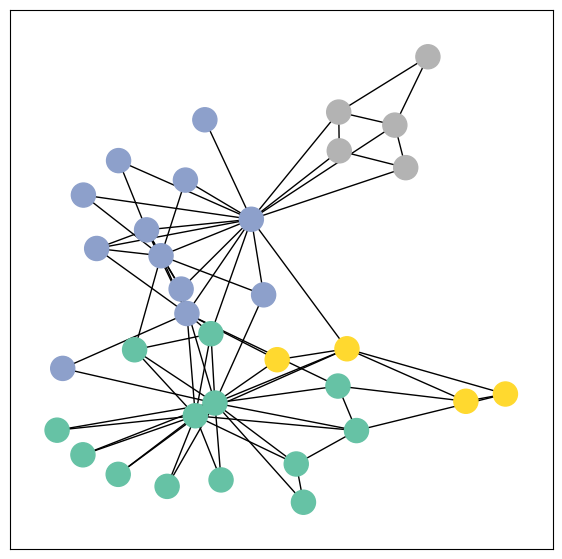

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Implementing Graph Neural Networks

After learning about PyG's data handling, it's time to implement our first Graph Neural Network!

For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


### Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

Embedding shape: [34, 2]


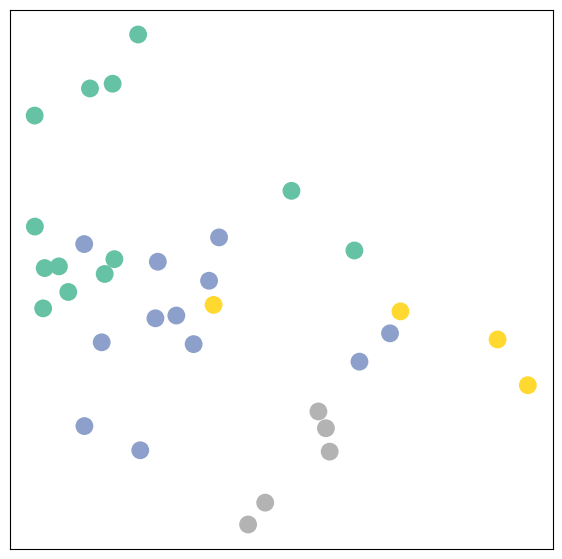

In [ ]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observse how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you.
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

<IPython.core.display.Javascript object>

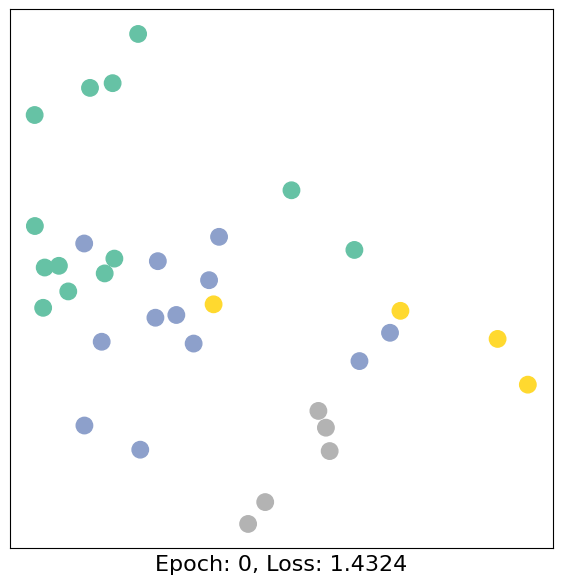

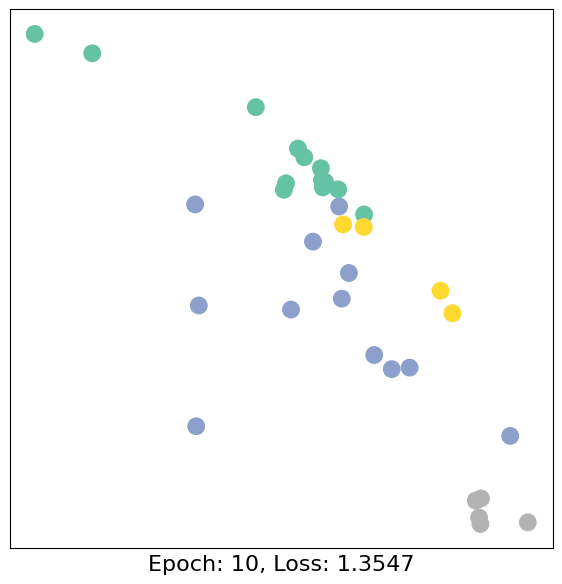

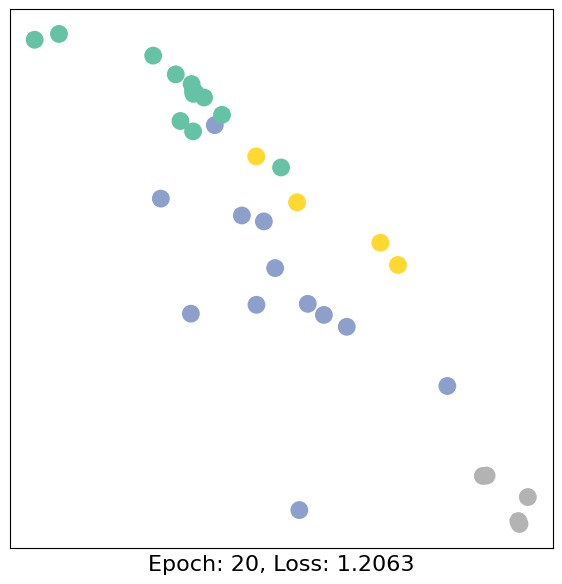

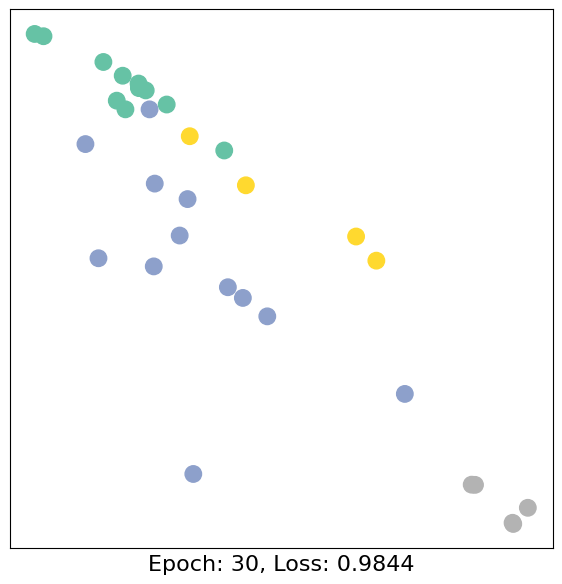

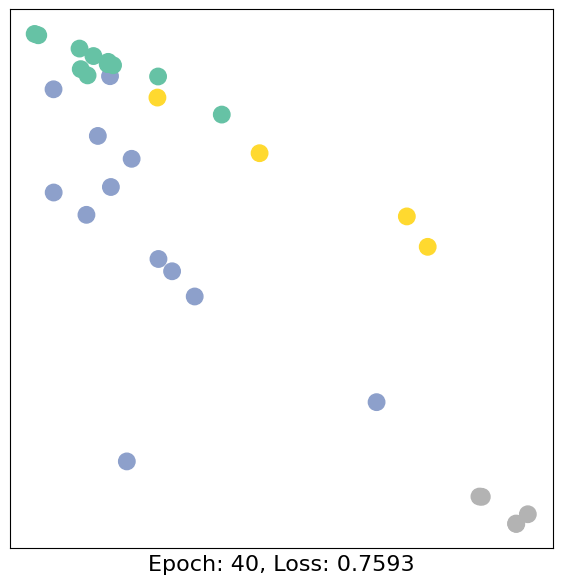

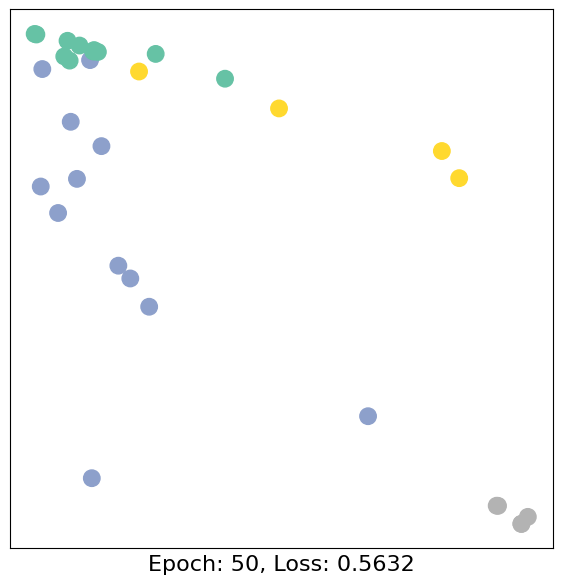

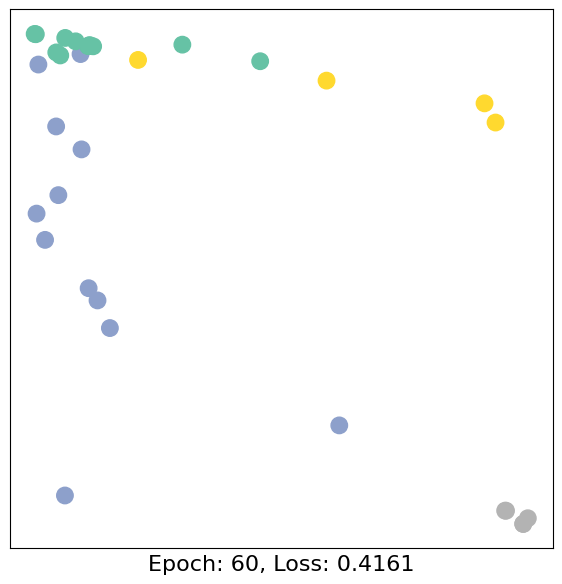

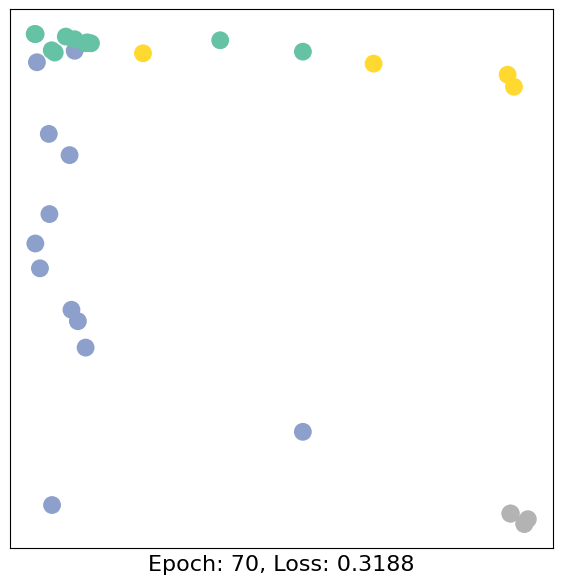

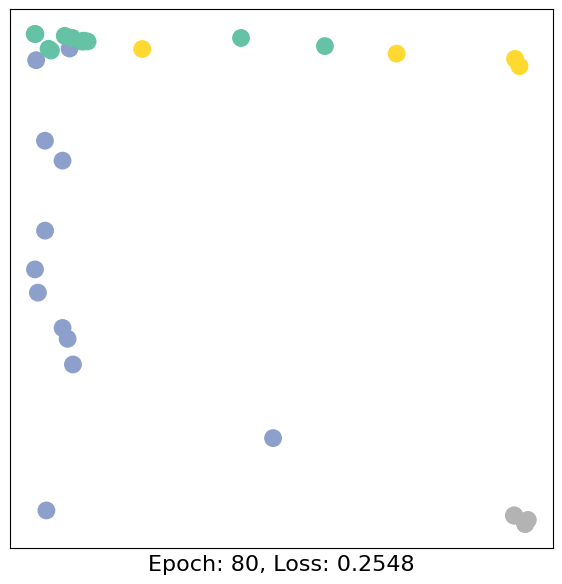

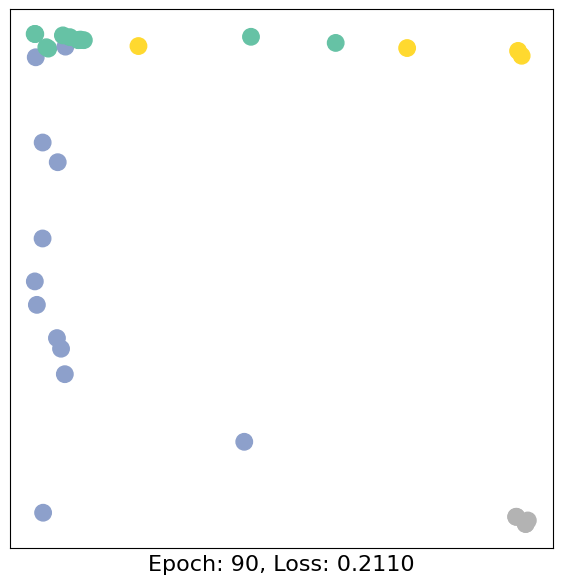

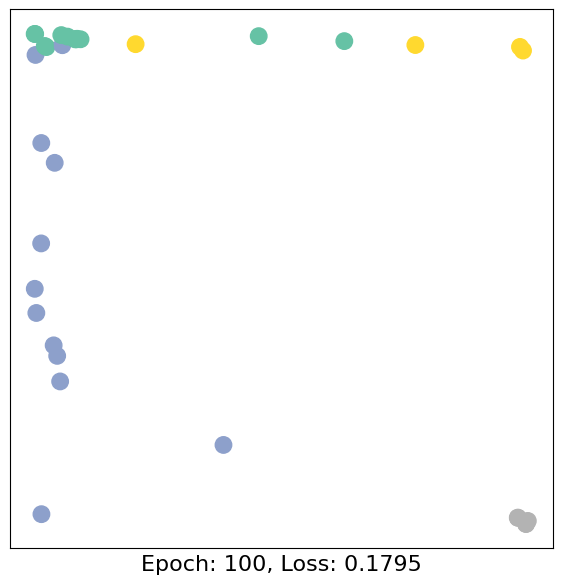

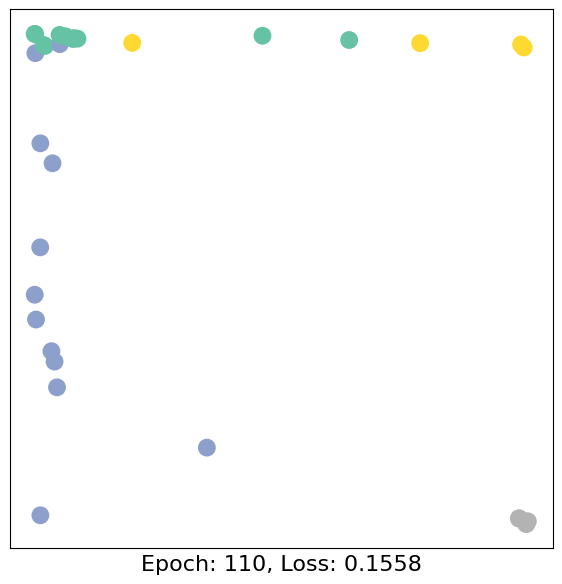

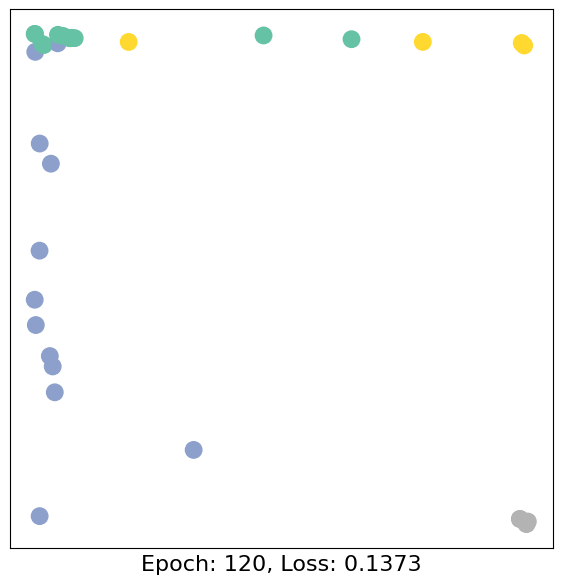

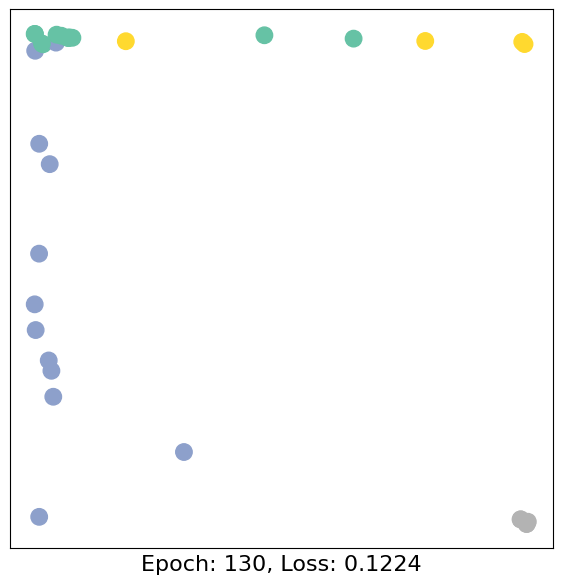

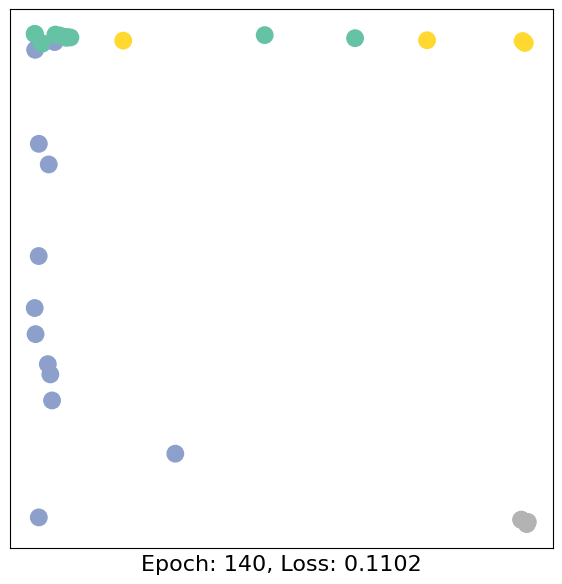

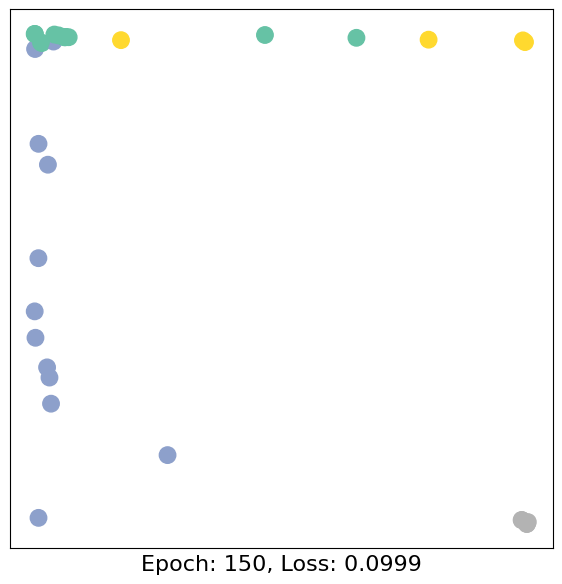

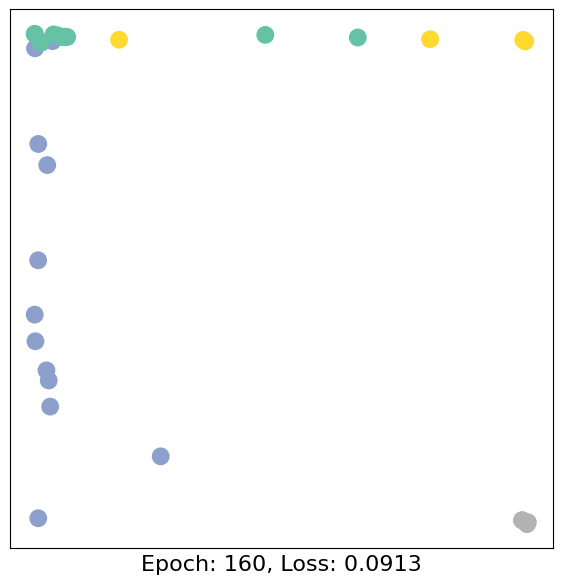

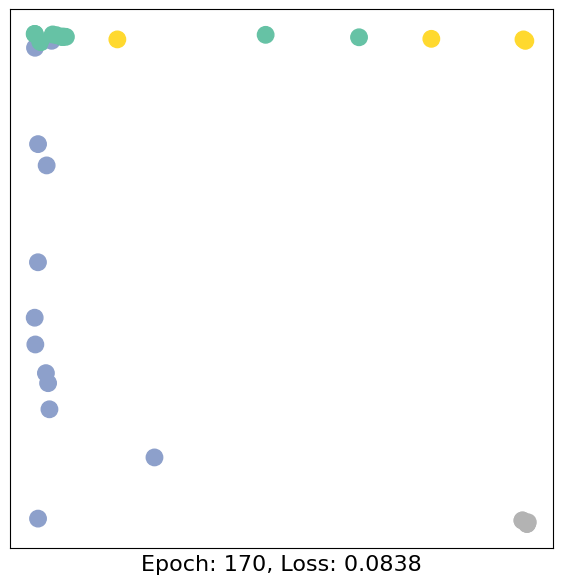

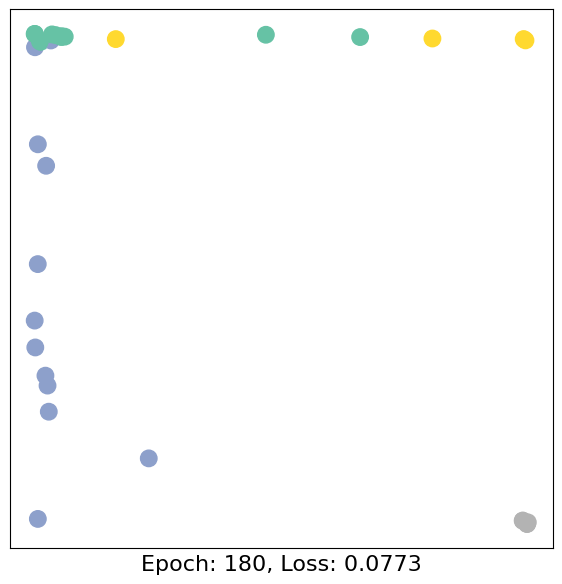

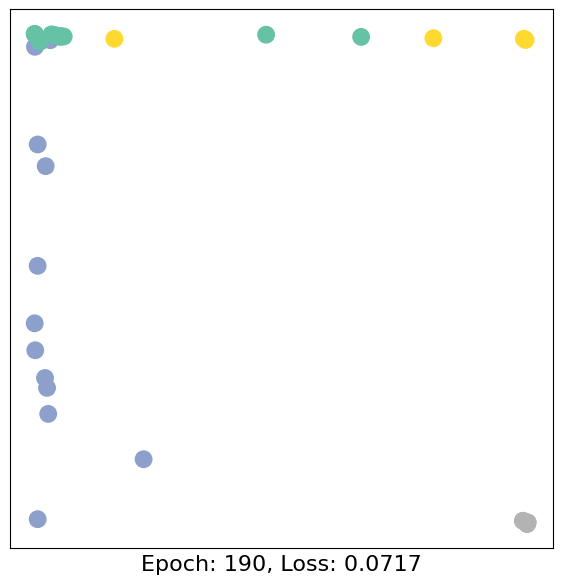

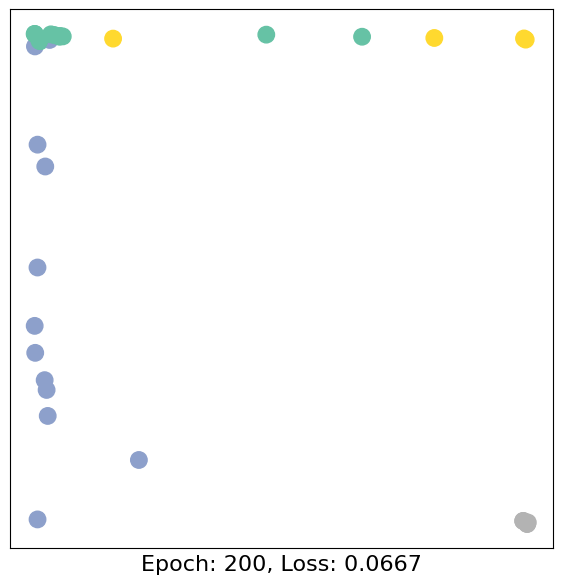

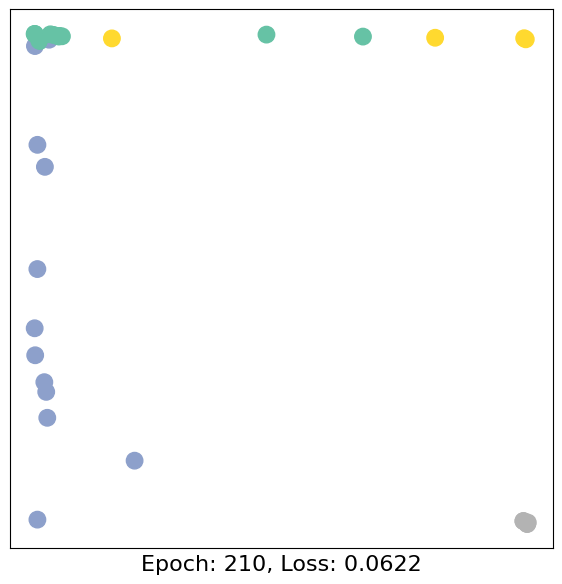

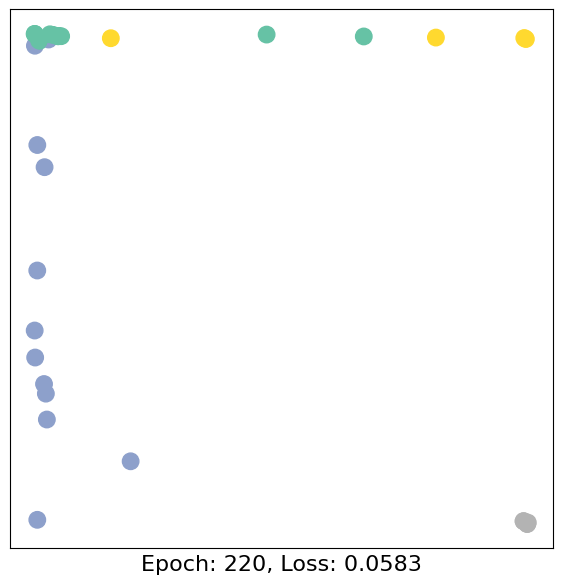

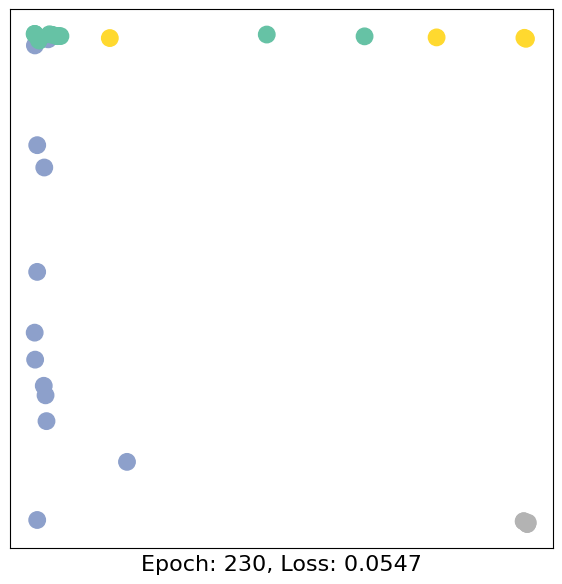

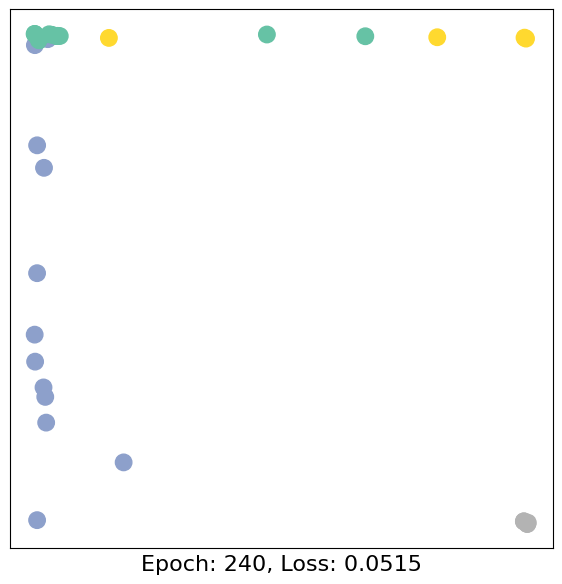

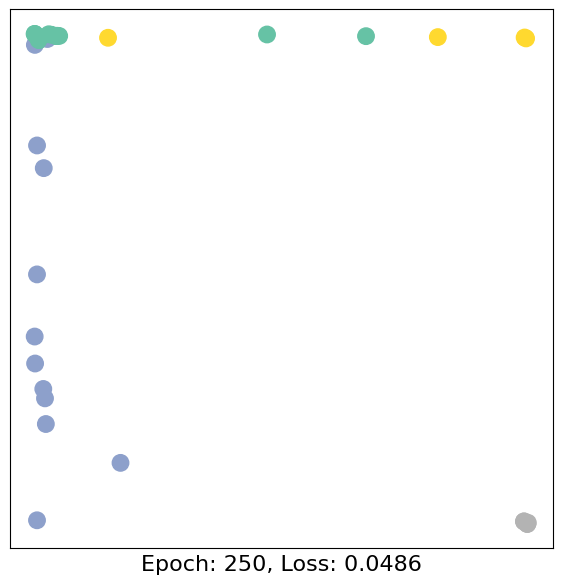

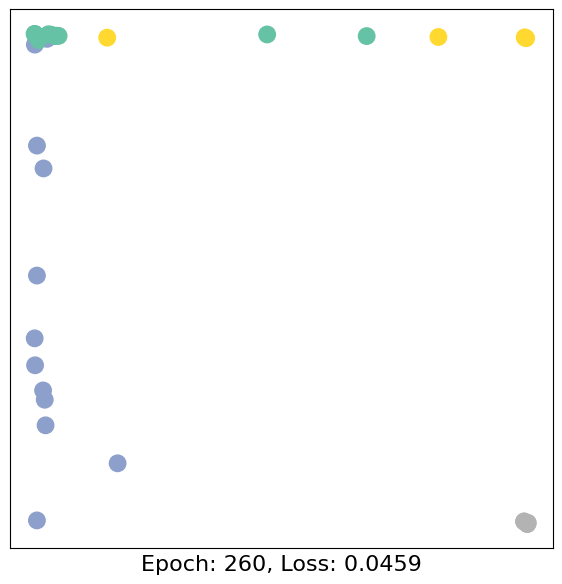

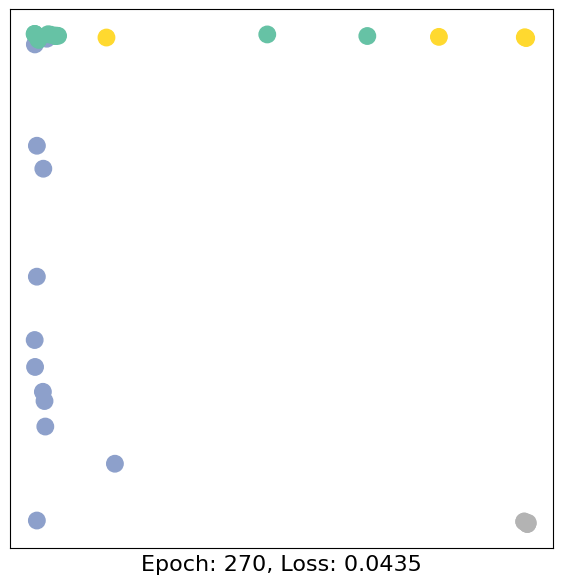

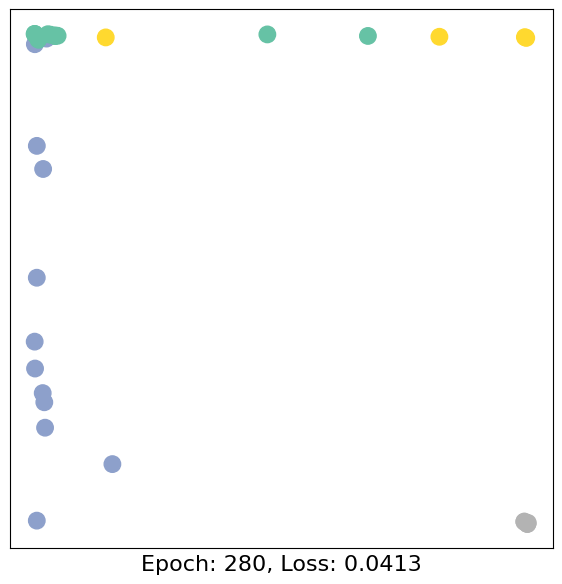

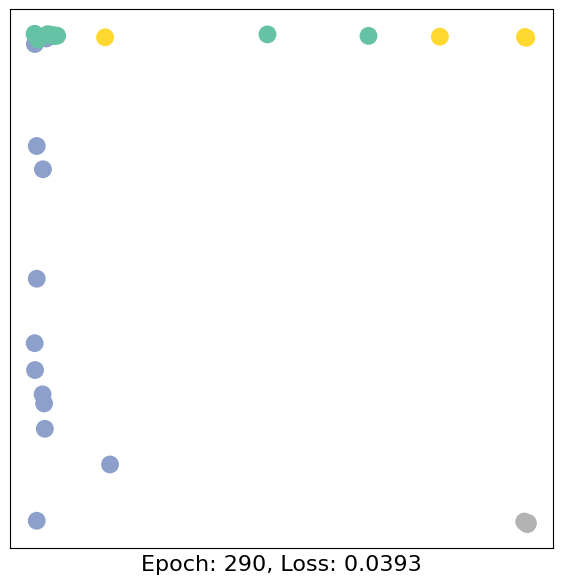

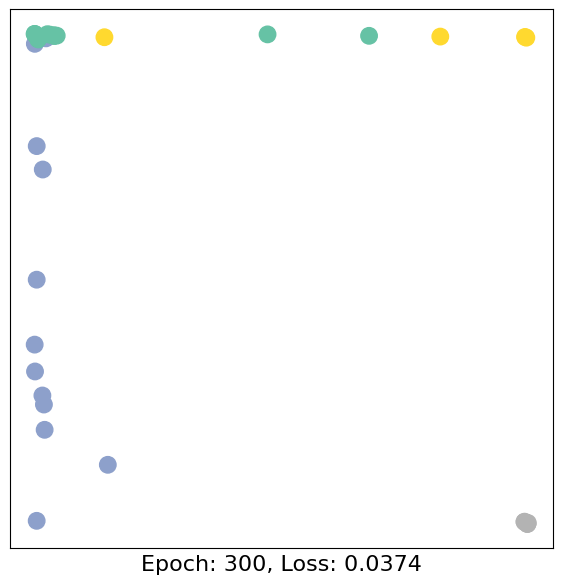

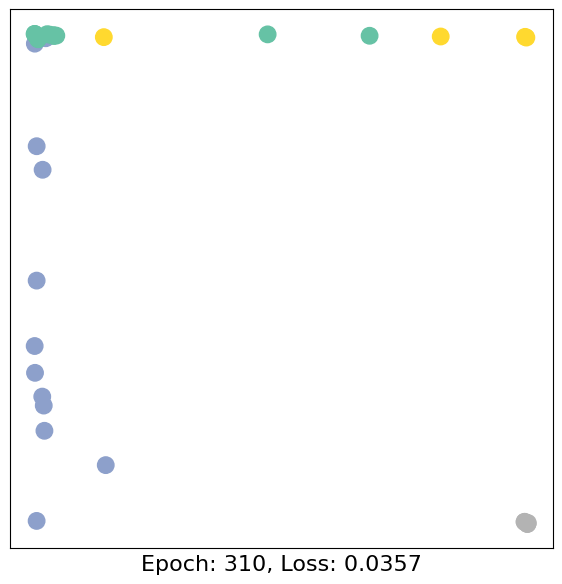

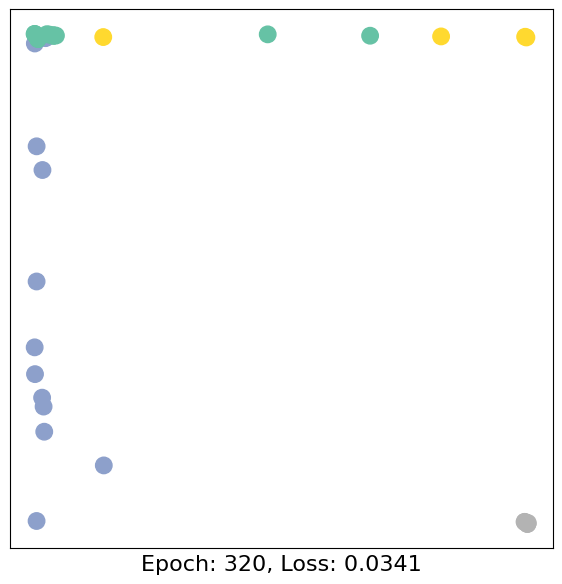

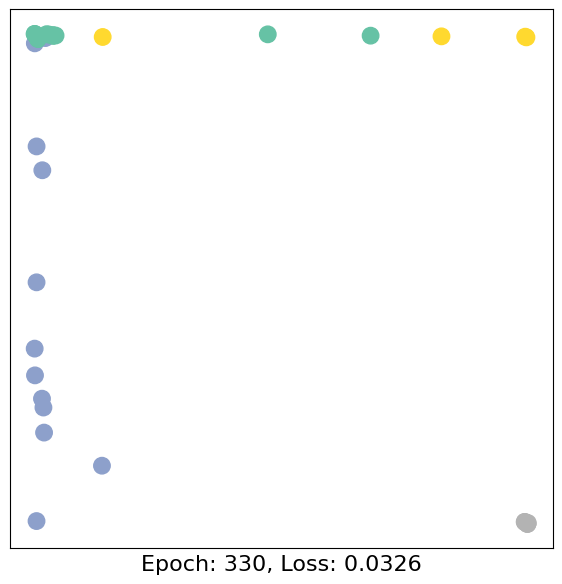

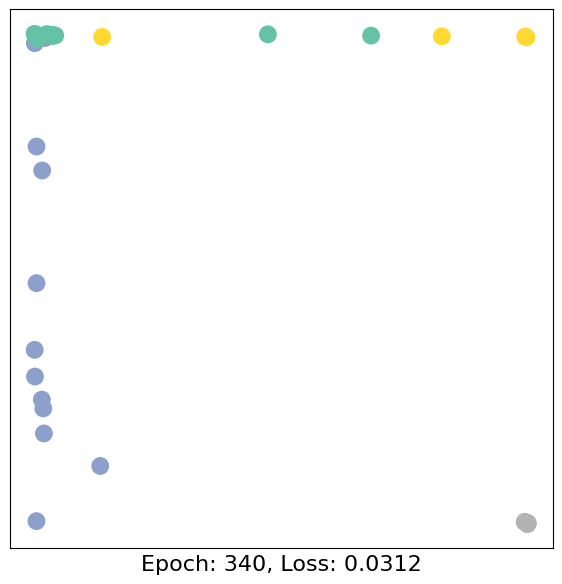

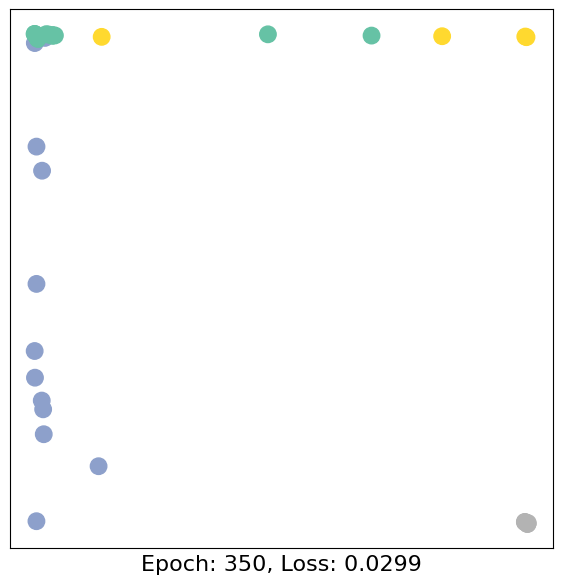

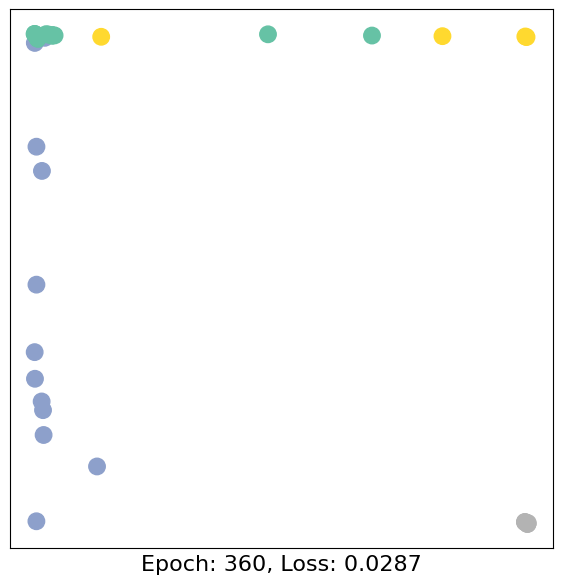

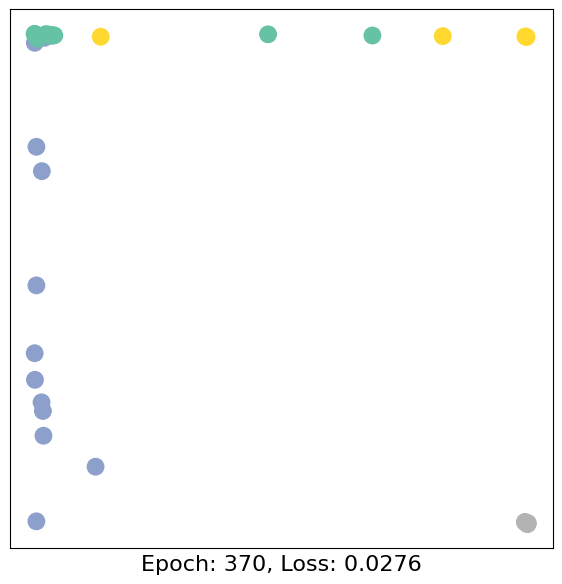

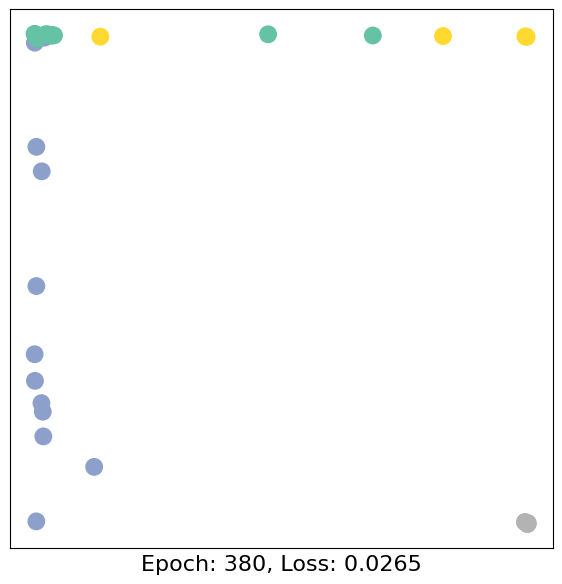

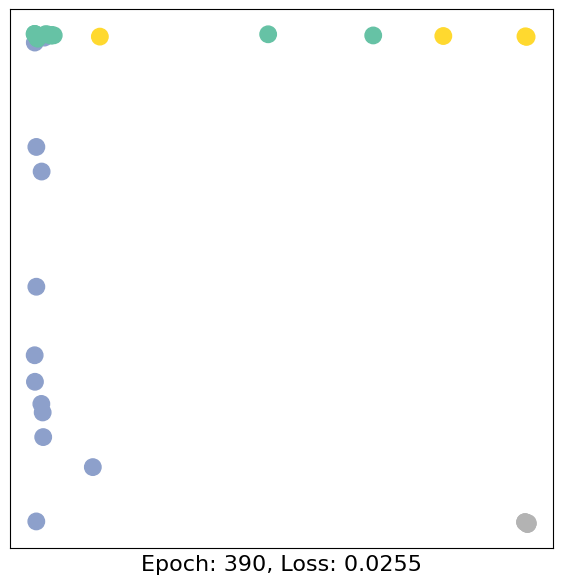

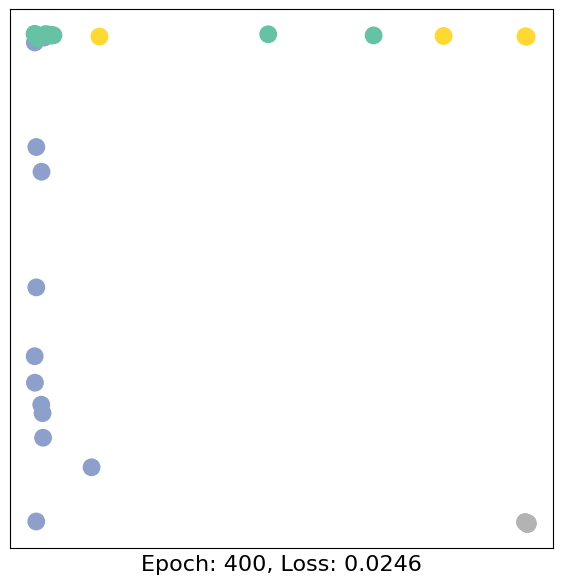

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

As one can see, our 3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the PyTorch Geometric library which helped us out with data handling and GNN implementations.

## Conclusion

This concludes the first introduction into the world of GNNs and PyTorch Geometric.
In the follow-up sessions, you will learn how to achieve state-of-the-art classification results on a number of real-world graph datasets.

[Next: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)
